In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Ridge, SGDRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVR
import xgboost as XGB
import lightgbm as lgb
import scipy.stats as stats
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from sklearn.inspection import permutation_importance

Importing training, testing datasets. 
Training set consists of 1.2 million samples and 20 features including Premium Amount
Test set consists of 800,000 samples

In [2]:
df = pd.read_csv('dataset/train.csv',index_col=0)
df_test = pd.read_csv('dataset/test.csv',index_col=0)
print('training data shape:',df.shape)
print('test data shape:',df_test.shape)

training data shape: (1200000, 20)
test data shape: (800000, 19)


## Plotting categorical features
The distribution of classes is quite even across features, with the exception of missing data. A lot of occupation data is missing.

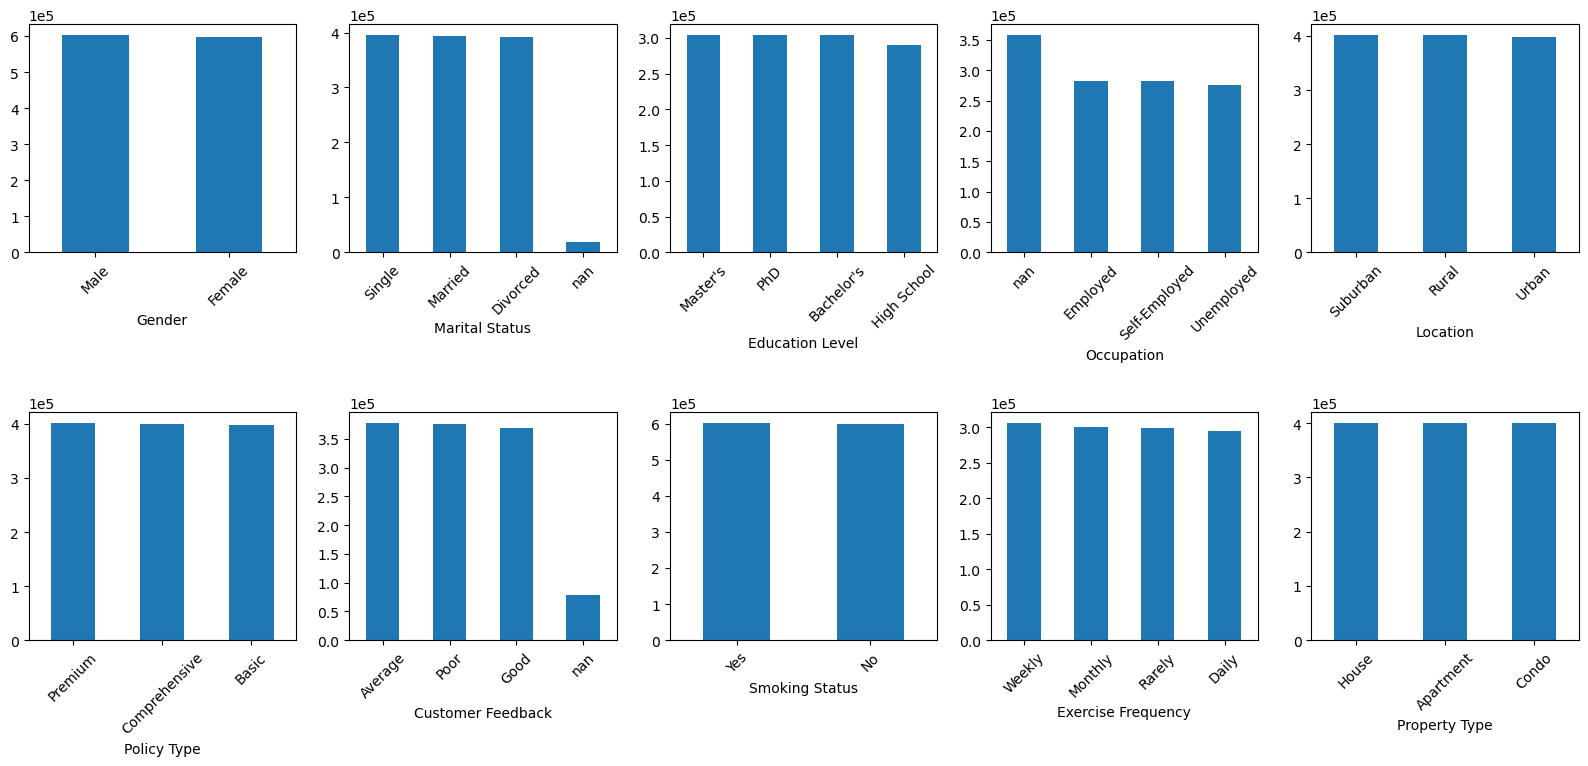

In [3]:
plt.figure(figsize=(20,8))
cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
for i,c in enumerate(cat_cols):
    plt.subplot(2,5,i+1)
    df[c].value_counts(dropna=False).plot(kind='bar')
    plt.ticklabel_format(axis='y',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.7)

## Plotting continuous features
Policy Start Date was converted to seconds since POSIX epoch so that it could be treated as a float. 
Age, Credit Score, Insurance Duration, Number of Dependents, Vehicle Age and Policy Start Date were all approximately uniformly distributed.
Annual Income, Premium Amount and Previous Claims were right-skewed
Health score was slightly right-skewed

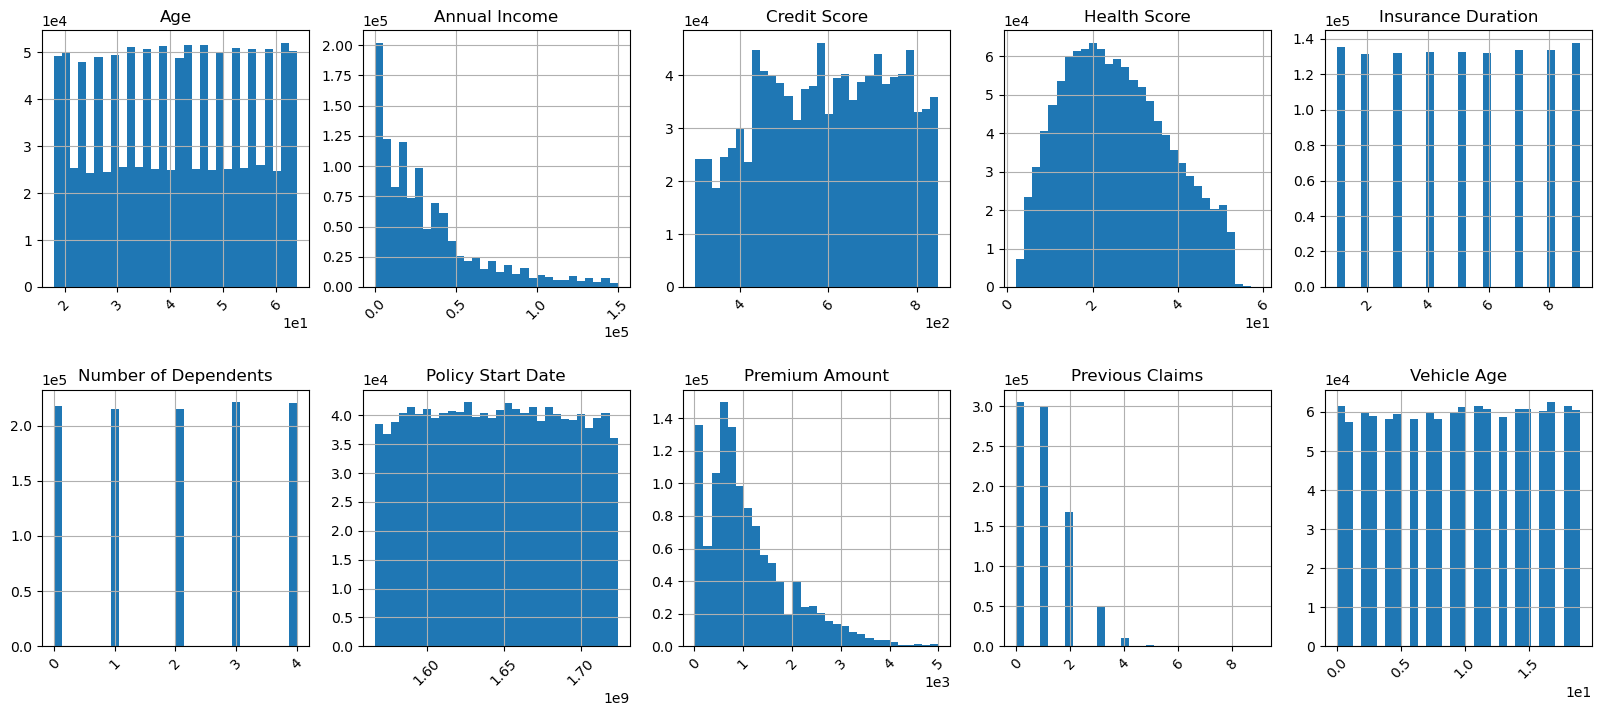

In [4]:
cont_cols = ['Age', 'Annual Income', 'Credit Score', 'Health Score',
       'Insurance Duration', 'Number of Dependents', 'Policy Start Date',
       'Premium Amount', 'Previous Claims', 'Vehicle Age']
plt.figure(figsize=(20,8))
for i,c in enumerate(cont_cols):
    plt.subplot(2,5,i+1)
    if c == 'Policy Start Date':
        pd.to_datetime(df[c]).apply(lambda x: x.timestamp()).hist(bins=30)
    else:
        df[c].hist(bins=30)
    plt.title(c)
    plt.ticklabel_format(axis='both',scilimits=(0,0))
    plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.4)

## Missing values
Certain features have missing values, with Occupation and Previous Claims having 30% missing

## Preprocessing function
Based on the previous observations, a function to preprocess the data was prepared.

Previous claims had many missing values and few values greater than 2- to include these it was converted to categorical

***UPDATE FOR CATEGORICAL FEATURES***: 

Instead of one-hot encoding, this notebook retains the features as categorical dtype for use in the HistGradientBoosting function (which supports native categorical features). This reduces the number of features needed and avoids the creation of sparse features. Many of the categorical features are not ordinal, and so cannot be represented as continuous data.

In [5]:
from feature_engine.creation import CyclicalFeatures

In [6]:
def preprocess_data(df):

    df['Education Level'] = df['Education Level'].replace({'High School':0,"Bachelor's":1,"Master's":2,"PhD":3}).astype('Int64')
    df['Location'] = df['Location'].replace({"Urban":0,"Suburban":1,"Rural":2}).astype('Int64')
    df['Customer Feedback'] = df['Customer Feedback'].replace({"Poor":0,"Average":1,"Good":2}).astype('Int64')
    df['Exercise Frequency'] = df['Exercise Frequency'].replace({"Rarely":0,"Monthly":1,"Weekly":2,"Daily":3}).astype('Int64')

    cat_cols = ['Gender','Marital Status', 'Occupation','Policy Type', 'Smoking Status','Property Type']
    # convert text features to categorical dtype after replacing missing values with new class
    for c in cat_cols:
        df[c] = df[c].astype('category')
    
    # df['Previous Claims'] = df['Previous Claims'].clip(0,2).replace({0:'none',1:'one',2:'two_or_more'}).astype('category')
    
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Weekday'] = df['Policy Start Date'].dt.dayofweek
    df['Weekday_sin'] = CyclicalFeatures(variables=['Weekday']).fit_transform(df)['Weekday_sin']
    df['Weekday_cos'] = CyclicalFeatures(variables=['Weekday']).fit_transform(df)['Weekday_cos']
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_cos'] = CyclicalFeatures(variables=['Month']).fit_transform(df)['Month_cos']
    df['Month_sin'] = CyclicalFeatures(variables=['Month']).fit_transform(df)['Month_sin']
    df['Day'] = df['Policy Start Date'].dt.day
    df['Day_cos'] = CyclicalFeatures(variables=['Day']).fit_transform(df)['Day_cos']
    df['Day_sin'] = CyclicalFeatures(variables=['Day']).fit_transform(df)['Day_sin']
    df.drop(columns=['Day','Month','Weekday'],inplace=True)
    df['Policy Start Date'] = df['Policy Start Date'].apply(lambda x: x.timestamp()) / (3600*24*365.25)
    df['Annual Income'] = np.log1p(df['Annual Income'])
    df['Health Score'] = np.log1p(df['Health Score'])

    cont_cols = np.setdiff1d(df.columns,cat_cols)
    # impute missing values for remaining continuous features
    #df[cont_cols] = df[cont_cols].fillna(df[cont_cols].median())

    df['Policy End Date'] = df['Policy Start Date'] + df["Insurance Duration"]

    if 'Premium Amount' in df.columns:
        df['Premium Amount'] = np.log1p(df['Premium Amount'])
    df['Num NA'] = df.isna().sum(axis=1)
    for c in df.columns:
        if c == 'Premium Amount':
            pass
        df['%s_NA'%c] = df[c].isna().astype('category')
    return df

In [7]:
df = preprocess_data(df)
df_test = preprocess_data(df_test)

# Q1 = df['Premium Amount'].quantile(0.25)
# Q3 = df['Premium Amount'].quantile(0.75)
# IQR = Q3 - Q1
# lower_limit = df['Premium Amount'].quantile(0.1) # Q1 - 1.5*IQR
# upper_limit = df['Premium Amount'].quantile(0.9) # Q3 + 1.5*IQR
# df = df.loc[(df['Premium Amount']>lower_limit) & (df['Premium Amount']<upper_limit)]

#df = df.loc[df['Premium Amount']>df['Premium Amount'].quantile(0.1)]

C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\1789343137.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Education Level'] = df['Education Level'].replace({'High School':0,"Bachelor's":1,"Master's":2,"PhD":3}).astype('Int64')
C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\1789343137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Location'] = df['Location'].replace({"Urban":0,"Suburban":1,"Rural":2}).astype('Int64')
C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\1789343137.py:5: FutureWarning: Downcasting be

In [8]:
cat_cols =  ['Gender','Marital Status', 'Education Level', 'Occupation','Location','Policy Type',
                'Customer Feedback', 'Smoking Status', 'Exercise Frequency','Property Type']
for c in cat_cols:
    display(df.groupby(c)['Premium Amount'].mean().round(3))

C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\529424396.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(c)['Premium Amount'].mean().round(3))


Gender
Female    6.595
Male      6.593
Name: Premium Amount, dtype: float64

Marital Status
Divorced    6.590
Married     6.592
Single      6.594
Name: Premium Amount, dtype: float64

Education Level
0    6.595
1    6.594
2    6.592
3    6.594
Name: Premium Amount, dtype: float64

C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\529424396.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(c)['Premium Amount'].mean().round(3))


Occupation
Employed         6.603
Self-Employed    6.595
Unemployed       6.596
Name: Premium Amount, dtype: float64

Location
0    6.596
1    6.593
2    6.592
Name: Premium Amount, dtype: float64

C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\529424396.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(c)['Premium Amount'].mean().round(3))


Policy Type
Basic            6.595
Comprehensive    6.594
Premium          6.593
Name: Premium Amount, dtype: float64

Customer Feedback
0    6.589
1    6.584
2    6.587
Name: Premium Amount, dtype: float64

C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\529424396.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(c)['Premium Amount'].mean().round(3))


Smoking Status
No     6.593
Yes    6.595
Name: Premium Amount, dtype: float64

Exercise Frequency
0    6.595
1    6.593
2    6.592
3    6.595
Name: Premium Amount, dtype: float64

C:\Users\Alex\AppData\Local\Temp\ipykernel_18036\529424396.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(c)['Premium Amount'].mean().round(3))


Property Type
Apartment    6.595
Condo        6.591
House        6.596
Name: Premium Amount, dtype: float64

In [9]:
df['Property Type_NA']

id
0          False
1          False
2          False
3          False
4          False
           ...  
1199995    False
1199996    False
1199997    False
1199998    False
1199999    False
Name: Property Type_NA, Length: 1200000, dtype: category
Categories (1, bool): [False]

In [10]:
abs(df[np.setdiff1d(df.columns,cat_cols)].corr()['Premium Amount']).sort_values()

Vehicle Age                0.000091
Day_cos                    0.000138
Day_sin                    0.000297
Policy End Date_NA         0.000298
Insurance Duration_NA      0.000298
Weekday_cos                0.000375
Insurance Duration         0.000440
Age_NA                     0.000452
Weekday_sin                0.000607
Vehicle Age_NA             0.000610
Number of Dependents       0.001676
Age                        0.002110
Month_cos                  0.002948
Month_sin                  0.003157
Policy End Date            0.003558
Number of Dependents_NA    0.004875
Occupation_NA              0.005893
Policy Start Date          0.008178
Num NA                     0.009704
Health Score               0.011554
Credit Score_NA            0.013272
Previous Claims_NA         0.014212
Marital Status_NA          0.014787
Customer Feedback_NA       0.024824
Previous Claims            0.036251
Health Score_NA            0.039380
Annual Income              0.049564
Credit Score               0

## Target definition
Premium Amount is the prediction target. The performance metric is the root mean square log error (RMSLE).
It differs from root mean square error (RMSE)in that RMSLE will penalize under-estimation more than over-estimation. To get good performance, we want to optimize our models for the squared log loss rather than the squared loss. However, squared loss is more commonly available as a loss in different ML algorithms. We can therefore take the log of the target in advance, so that we are effectively optimizing for RMSLE

In [11]:
#target = df['Premium Amount']
# competition metric is root mean square log loss -> log-transform target first so that can use common mean-squares losses to optimize for the root mean square log loss
# will convert back predictions later
#transformed_target = np.log1p(target)
X = df.drop(columns='Premium Amount')
Y = df['Premium Amount']

# # Remove outliers
# Q1 = Y.quantile(0.25)
# Q3 = Y.quantile(0.75)
# IQR = Q3 - Q1
# lower_limit = Q1 - 1.5*IQR
# upper_limit = Q3 + 1.5*IQR
# Y = Y.loc[(Y>lower_limit) & (Y<upper_limit)]
# X = X.loc[Y.index]


xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.9)

## Model fitting
Optimization using grid search and experiments with feature subsets were conducted. Minimal improvement was observed, and the biggest difference was between algorithms.

In [12]:
import optuna

c:\Users\Alex\anaconda3\envs\Portfolio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def objective(trial):
    lr = trial.suggest_float('lr',1e-3,.1,log=True)
    min_samples_leaf = trial.suggest_int('minsamplesleaf',1,100,log=True)
    max_leaf_nodes = trial.suggest_int('maxleafnodes',31,500, log=True)
    max_iter = trial.suggest_int('maxiter',100,3000,log=True)
    max_features = trial.suggest_float('maxfeats',0.1,1.)
    l2_regularization = trial.suggest_float('l2reg',1e-4,1,log=True)

    reg = HistGradientBoostingRegressor(
        categorical_features='from_dtype',
        learning_rate=lr,
        min_samples_leaf=min_samples_leaf,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        max_features=max_features,
        l2_regularization=l2_regularization
    )
    return np.mean(
        cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)
    )

In [14]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

[I 2024-12-18 22:26:39,537] A new study created in memory with name: no-name-d75781f3-e06b-4d72-b83f-b75babf01a40


[I 2024-12-18 22:34:52,283] Trial 0 finished with value: -1.0456071887654868 and parameters: {'lr': 0.009556893119945184, 'minsamplesleaf': 2, 'maxleafnodes': 62, 'maxiter': 2435, 'maxfeats': 0.5870212588487329, 'l2reg': 0.00024929601355316925}. Best is trial 0 with value: -1.0456071887654868.
[I 2024-12-18 22:42:55,519] Trial 1 finished with value: -1.0497124905338229 and parameters: {'lr': 0.006507446375802516, 'minsamplesleaf': 53, 'maxleafnodes': 98, 'maxiter': 658, 'maxfeats': 0.1206982008270539, 'l2reg': 0.7321946777942825}. Best is trial 0 with value: -1.0456071887654868.
[I 2024-12-18 22:45:32,210] Trial 2 finished with value: -1.0595955122415233 and parameters: {'lr': 0.004531829865094575, 'minsamplesleaf': 1, 'maxleafnodes': 203, 'maxiter': 148, 'maxfeats': 0.5082006487827947, 'l2reg': 0.15617324404759186}. Best is trial 0 with value: -1.0456071887654868.
[I 2024-12-18 22:47:40,103] Trial 3 finished with value: -1.0850014457535995 and parameters: {'lr': 0.002059410492099619, 

In [16]:
study.best_params

{'lr': 0.016481472082907022,
 'minsamplesleaf': 6,
 'maxleafnodes': 50,
 'maxiter': 1923,
 'maxfeats': 0.7240295654420636,
 'l2reg': 0.00014519550640048023}

Optuna best params: 
{'lr': 0.016481472082907022,
 'minsamplesleaf': 6,
 'maxleafnodes': 50,
 'maxiter': 1923,
 'maxfeats': 0.7240295654420636,
 'l2reg': 0.00014519550640048023}

In [21]:
reg = HistGradientBoostingRegressor(
    categorical_features='from_dtype',    
)
reg.set_params(**{'learning_rate': 0.016481472082907022,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 50,
 'max_iter': 1923,
 'max_features': 0.7240295654420636,
 'l2_regularization': 0.00014519550640048023})
# print('%.4f'%np.mean(
#     cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)
# ))

HistGradientBoostingRegressor(categorical_features='from_dtype',
                              l2_regularization=0.00014519550640048023,
                              learning_rate=0.016481472082907022,
                              max_features=0.7240295654420636, max_iter=1923,
                              max_leaf_nodes=50, min_samples_leaf=6)

## Permutation feature importance

In [22]:
reg.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest)))
importance = permutation_importance(reg,xtest,ytest,scoring='neg_mean_squared_error',n_jobs=-1)
importance.pop('importances')
importance = pd.DataFrame().from_dict(importance)
importance.index = xtrain.columns

train: 1.0421302354455595
test: 1.0459397021344017


<Axes: >

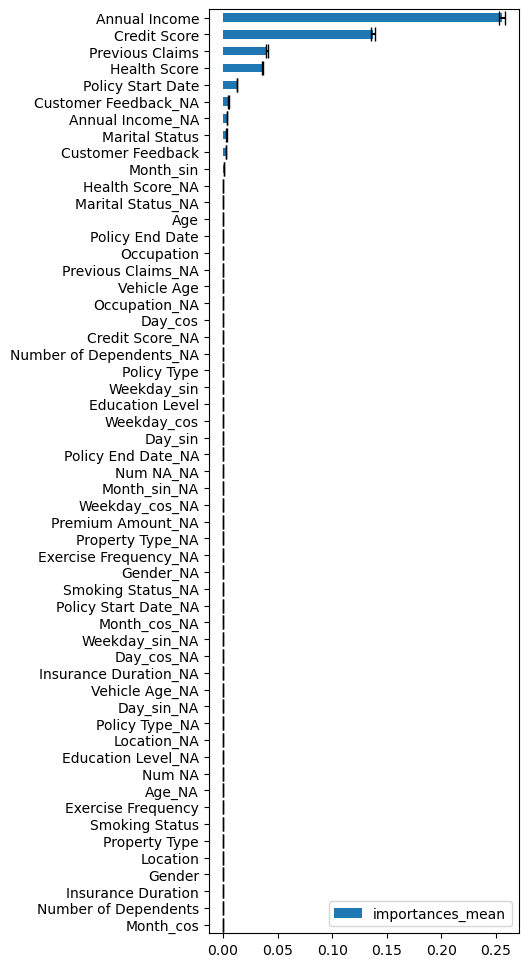

In [23]:
importance.sort_values(by='importances_mean').plot(kind='barh',xerr='importances_std',capsize=5,figsize=(4,12))

In [31]:
net_contrib_cols = importance.query('importances_mean > 0')['importances_mean'].index

In [32]:
print('%.4f'%np.mean(
    cross_val_score(reg,X[net_contrib_cols],Y,scoring='neg_root_mean_squared_error',cv=5)
))

-1.0458


In [33]:
reg = XGB.XGBRegressor(
    enable_categorical=True
)
print('%.4f'%np.mean(
    cross_val_score(reg,X,Y,scoring='neg_root_mean_squared_error',cv=5)
))

-1.0477


## Permutation feature importance

In [34]:
reg.fit(xtrain,ytrain)
print('train:',root_mean_squared_error(ytrain,reg.predict(xtrain)))
print('test:',root_mean_squared_error(ytest,reg.predict(xtest)))
importance = permutation_importance(reg,xtest,ytest,scoring='neg_mean_squared_error',n_jobs=-1)
importance.pop('importances')
importance = pd.DataFrame().from_dict(importance)
importance.index = xtrain.columns

train: 1.0344662187222722
test: 1.0479211339097703


<Axes: >

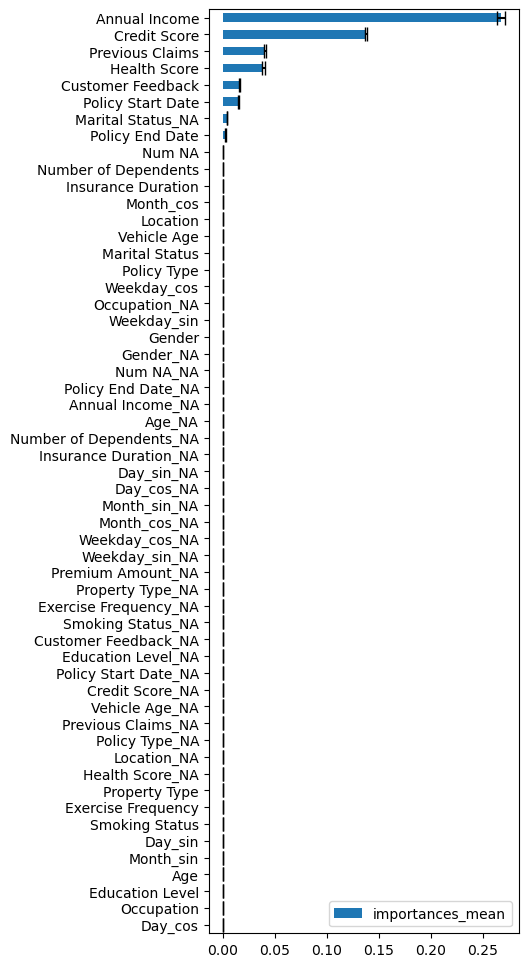

In [35]:
importance.sort_values(by='importances_mean').plot(kind='barh',xerr='importances_std',capsize=5,figsize=(4,12))

In [ ]:
# Stacking model with all features
hist = HistGradientBoostingRegressor(
    categorical_features='from_dtype',    
)
hist.set_params(**{'learning_rate': 0.016481472082907022,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 50,
 'max_iter': 1923,
 'max_features': 0.7240295654420636,
 'l2_regularization': 0.00014519550640048023})

pipe = StackingRegressor([
    ('HistGBR',hist),
    ('XGB',XGB.XGBRegressor(enable_categorical=True))],verbose=3,cv=5,n_jobs=-1)
print('%.4f'%np.mean(cross_val_score(pipe,X,Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0455


In [37]:
# Stacking model with reduced features
hist = HistGradientBoostingRegressor(
    categorical_features='from_dtype',    
)
hist.set_params(**{'learning_rate': 0.016481472082907022,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 50,
 'max_iter': 1923,
 'max_features': 0.7240295654420636,
 'l2_regularization': 0.00014519550640048023})

pipe = StackingRegressor([
    ('HistGBR',hist),
    ('XGB',XGB.XGBRegressor(enable_categorical=True))],verbose=3,cv=5,n_jobs=-1)
print('%.4f'%np.mean(cross_val_score(pipe,X[net_contrib_cols],Y,scoring='neg_root_mean_squared_error',cv=5)))

-1.0455


## Create predictions for submission

In [40]:
pipe.fit(X[net_contrib_cols],Y)
pred = np.expm1(pipe.predict(df_test[net_contrib_cols]))
pd.DataFrame().from_dict({'id':df_test.index,'Premium Amount':pred}).to_csv('my_sample_submission.csv',index=False)